In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)
# we use regex here to parse the output log files
import re

Populating the interactive namespace from numpy and matplotlib


In [2]:
# global variables
FOLDER_PREFIX="worker"

worker_num_interval = [2, 4, 8, 16, 32]
# single node means, we have single worker node in cluster (ps+worker0)
single_node_time=526.16
# signle machine means we only consider training on local machine, thus there is no communication cost
single_machine_time=526.16

In [3]:
global_dict_saver = []
for num_w in worker_num_interval:
    # master is also include in this one, so the first worker should be the master
    time_stats_dict = {}
    for worker_index in range(num_w):
        if worker_index == 0:
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_master', 'rb')
        else:
            # for the case of 8 workers, we only consider master, worker0,...,worker6
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_worker_'+str(worker_index-1), 'rb')
        for line in out_file.readlines():
            line_string = line.rstrip('\n')
            search_sth = re.match('INFO:tensorflow:Worker(.*): (.*): step (.*), loss = (.*).* examples/sec; (.*) sec/batch.*', line_string)
            if search_sth:
                worker_index, cur_step, worker_time_cost = int(search_sth.group(1)), int(search_sth.group(3)), float(search_sth.group(5))
                if cur_step <= 40:
                    #print(worker_index, cur_step, worker_time_cost)
                    if cur_step not in time_stats_dict.keys():
                        time_stats_dict[cur_step]=[worker_time_cost]
                    else:
                        time_stats_dict[cur_step].append(worker_time_cost)
    global_dict_saver.append(time_stats_dict)

normal_speedup_vals = [1.0,]
ideal_speedup_vals = [1.0,]
normal_speedup_vals_local = [1.0,]
ideal_speedup_vals_local = [1.0,]
for dict_idx, stat_dict in enumerate(global_dict_saver):
    ideal_counter_ = 0
    full_counter_ = 0
    for k, v in stat_dict.iteritems():
        sorted_v = sorted(v)
        #ideal_counter_+=sorted_v[0]
        #full_counter_+=sorted_v[worker_num_interval[dict_idx]-1]
        ideal_counter_+=min(v)
        full_counter_+=max(v)
    normal_speedup_vals.append(float(single_node_time)/full_counter_)
    ideal_speedup_vals.append(float(single_node_time)/ideal_counter_)
    normal_speedup_vals_local.append(float(single_machine_time)/full_counter_)
    ideal_speedup_vals_local.append(float(single_machine_time)/ideal_counter_)
    print("Cluster set up with {} workers: ideal time: {} full time:{}".format(worker_num_interval[dict_idx], ideal_counter_, full_counter_))

Cluster set up with 2 workers: ideal time: 258.733 full time:263.08
Cluster set up with 4 workers: ideal time: 132.355 full time:135.148
Cluster set up with 8 workers: ideal time: 66.279 full time:81.005
Cluster set up with 16 workers: ideal time: 34.308 full time:44.141
Cluster set up with 32 workers: ideal time: 47.809 full time:72.277


# Speedup Comparisons between TF and MPI

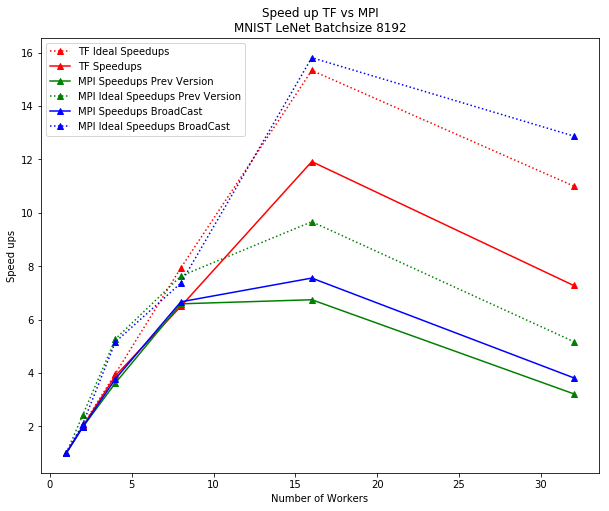

In [4]:
workers_interval=[1, 2, 4, 8, 16, 32]
normal_speedup_vals_mpi_previous=[1, 1.97, 3.625, 6.5909, 6.744, 3.22]
ideal_speedup_vals_mpi_previous=[1, 2.4167, 5.2727, 7.6316, 9.6667, 5.1786]
normal_speedup_vals_mpi_broadCast=[1, 1.9653, 3.7778, 6.6667, 7.5556, 3.8202]
ideal_speedup_vals_mpi_broadCast=[1, 2.0859, 5.1640, 7.368877, 15.8139, 12.87878]
fig = plt.figure(1)
plt.plot(workers_interval, ideal_speedup_vals, ':^r', label='TF Ideal Speedups')
plt.plot(workers_interval, normal_speedup_vals, '-^r', label='TF Speedups')
plt.plot(workers_interval, normal_speedup_vals_mpi_previous, '-^g', label='MPI Speedups Prev Version')
plt.plot(workers_interval, ideal_speedup_vals_mpi_previous, ':^g', label='MPI Ideal Speedups Prev Version')
plt.plot(workers_interval, normal_speedup_vals_mpi_broadCast, '-^b', label='MPI Speedups BroadCast')
plt.plot(workers_interval, ideal_speedup_vals_mpi_broadCast, ':^b', label='MPI Ideal Speedups BroadCast')
plt.title("Speed up TF vs MPI\nMNIST LeNet Batchsize 8192")
plt.xlabel("Number of Workers")
plt.ylabel("Speed ups")
plt.legend()
plt.savefig("straggler_ideal_speedup_comparison.jpg", dpi=300)
plt.show()

# Speedups of Cifar10 on ResNet-18

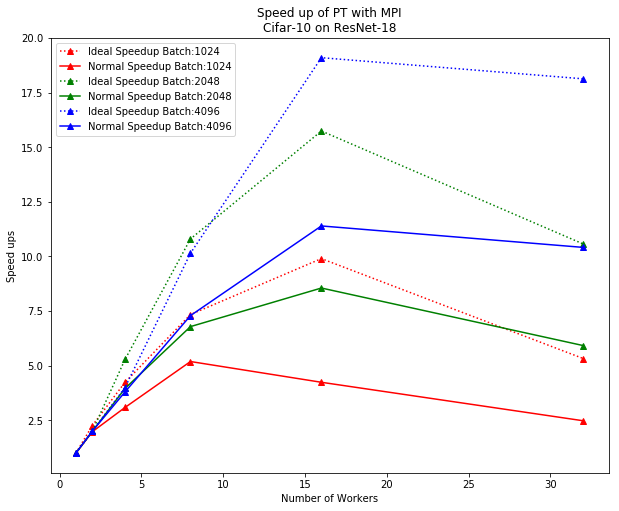

In [6]:
num_worker_interval = [1, 2, 4, 8, 16 ,32]
# batch size at 1024
normal_speedup_b1k = [1, 1.9737, 3.0871, 5.1896, 4.2394, 2.4774]
ideal_speedup_b1k = [1, 2.2547, 4.2394, 7.3414, 9.9013, 5.3274]

# batch size at 2048
normal_speedup_b2k = [1, 1.9937, 3.9572, 6.7889, 8.5549, 5.92]
ideal_speedup_b2k = [1, 2.0, 5.2857, 10.8029, 15.74468, 10.5714]

# batch size at 4096
normal_speedup_b4k = [1, 1.999, 3.799, 7.2922, 11.39739, 10.4150]
ideal_speedup_b4k = [1, 2.0, 4.0, 10.1493, 19.1011, 18.13333]

fig_2 = plt.figure()
plt.plot(num_worker_interval, ideal_speedup_b1k, ':^r', label='Ideal Speedup Batch:1024')
plt.plot(num_worker_interval, normal_speedup_b1k, '-^r', label='Normal Speedup Batch:1024')
plt.plot(num_worker_interval, ideal_speedup_b2k, ':^g', label='Ideal Speedup Batch:2048')
plt.plot(num_worker_interval, normal_speedup_b2k, '-^g', label='Normal Speedup Batch:2048')
plt.plot(num_worker_interval, ideal_speedup_b4k, ':^b', label='Ideal Speedup Batch:4096')
plt.plot(num_worker_interval, normal_speedup_b4k, '-^b', label='Normal Speedup Batch:4096')
plt.title("Speed up of PT with MPI\nCifar-10 on ResNet-18")
plt.xlabel("Number of Workers")
plt.ylabel("Speed ups")
plt.legend()
#plt.savefig("straggler_ideal_speedup_comparison.jpg", dpi=300)
plt.show()

# Speedups of Cifar10 on ResNet-34

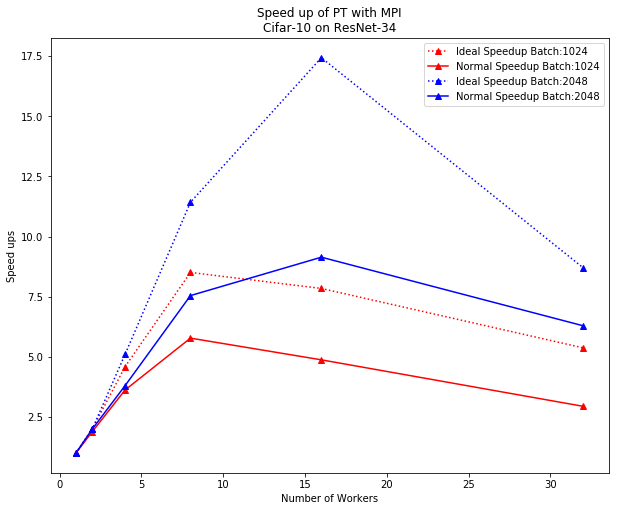

In [8]:
num_worker_interval = [1, 2, 4, 8, 16 ,32]
# batch size at 1024
normal_speedup_b1k = [1, 1.89, 3.61855, 5.7778, 4.875, 2.9422]
ideal_speedup_b1k = [1, 2.0, 4.5882, 8.5090, 7.8435, 5.3731]

# batch size at 2048
normal_speedup_b2k = [1, 1.999, 3.799, 7.5471, 9.1428, 6.2910]
ideal_speedup_b2k = [1, 2.0, 5.1, 11.4285, 17.4387, 8.70038]

fig_2 = plt.figure()
plt.plot(num_worker_interval, ideal_speedup_b1k, ':^r', label='Ideal Speedup Batch:1024')
plt.plot(num_worker_interval, normal_speedup_b1k, '-^r', label='Normal Speedup Batch:1024')
plt.plot(num_worker_interval, ideal_speedup_b2k, ':^b', label='Ideal Speedup Batch:2048')
plt.plot(num_worker_interval, normal_speedup_b2k, '-^b', label='Normal Speedup Batch:2048')
plt.title("Speed up of PT with MPI\nCifar-10 on ResNet-34")
plt.xlabel("Number of Workers")
plt.ylabel("Speed ups")
plt.legend()
#plt.savefig("straggler_ideal_speedup_comparison.jpg", dpi=300)
plt.show()